<a href="https://colab.research.google.com/github/arpitad791/BajajFinservQualifier1/blob/main/vit_for_further_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install vit-pytorch
!pip install scipy
!pip install scikit-learn
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 11.5 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import torch

# Set seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Enhanced augmentation function
def advanced_augment_patch(patch):
    # Original augmentations
    if random.random() > 0.5:
        patch = np.flip(patch, axis=0)  # vertical flip
    if random.random() > 0.5:
        patch = np.flip(patch, axis=1)  # horizontal flip
    if random.random() > 0.5:
        patch = np.rot90(patch, k=random.randint(1,3), axes=(0,1))

    # New spectral augmentations
    if random.random() > 0.7:
        # Add spectral noise
        noise = np.random.normal(0, 0.005, patch.shape)
        patch = patch + noise

    if random.random() > 0.8:
        # Spectral band dropout
        num_bands_to_drop = int(0.05 * patch.shape[2])  # Drop 5% of bands
        if num_bands_to_drop > 0:
            dropout_bands = np.random.choice(patch.shape[2], size=num_bands_to_drop, replace=False)
            patch_copy = patch.copy()
            patch_copy[:, :, dropout_bands] = 0
            patch = patch_copy

    if random.random() > 0.7:
        # Brightness adjustment
        factor = np.random.uniform(0.9, 1.1)
        patch = patch * factor

    return patch

# Data normalization function
def normalize_hyperspectral(data):
    """Z-score normalization per spectral band"""
    mean = np.mean(data, axis=(0,1), keepdims=True)
    std = np.std(data, axis=(0,1), keepdims=True)
    normalized = (data - mean) / (std + 1e-8)
    return normalized

In [ ]:
import os
import urllib.request
import scipy.io as sio
import numpy as np
from sklearn.decomposition import PCA

# Download the files (if not already present)
if not (os.path.exists('Indian_pines_corrected.mat') and os.path.exists('Indian_pines_gt.mat')):
    print("Downloading Indian Pines dataset...")
    urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat', 'Indian_pines_corrected.mat')
    urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat', 'Indian_pines_gt.mat')
    print("Download completed!")

# Load the .mat files
print("Loading data...")
image = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']  # shape: (145, 145, 200)
gt = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']  # shape: (145, 145)

print(f"Original image shape: {image.shape}")
print(f"Ground truth shape: {gt.shape}")
print(f"Number of classes: {len(np.unique(gt)) - 1}")  # -1 for background

# Apply normalization
print("Applying normalization...")
image = normalize_hyperspectral(image)

# Optional: Apply PCA for dimensionality reduction (uncomment if needed)
# print("Applying PCA...")
# original_shape = image.shape
# image_reshaped = image.reshape(-1, original_shape[-1])
# pca = PCA(n_components=100)  # Reduce to 100 components
# image_pca = pca.fit_transform(image_reshaped)
# image = image_pca.reshape(original_shape[0], original_shape[1], -1)
# print(f"Image shape after PCA: {image.shape}")

# Comprehensive patch extraction
def extract_patches_comprehensive(image, gt, patch_size=8):
    half = patch_size // 2
    patches = []
    labels = []

    print("Extracting patches...")

    # Strategy 1: Extract all valid patches
    for i in range(half, image.shape[0] - half):
        for j in range(half, image.shape[1] - half):
            if gt[i, j] != 0:
                patch = image[i-half:i+half, j-half:j+half, :]
                patches.append(patch)
                labels.append(gt[i, j] - 1)

    # Strategy 2: Balance dataset by oversampling minority classes
    labels_array = np.array(labels)
    unique_labels, counts = np.unique(labels_array, return_counts=True)

    print("Class distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Class {label}: {count} samples")

    # Find minority classes (less than median count)
    median_count = np.median(counts)
    minority_classes = unique_labels[counts < median_count * 0.5]

    print(f"Oversampling minority classes: {minority_classes}")

    # Oversample minority classes
    for minority_class in minority_classes:
        class_indices = np.where(labels_array == minority_class)[0]
        current_count = len(class_indices)
        target_count = int(median_count * 0.8)  # Target 80% of median

        if current_count < target_count:
            oversample_count = target_count - current_count
            oversample_indices = np.random.choice(class_indices, size=oversample_count, replace=True)

            for idx in oversample_indices:
                # Add original patch
                patches.append(patches[idx])
                labels.append(labels[idx])

    patches = np.array(patches)
    labels = np.array(labels)

    print(f"Total patches extracted: {len(patches)}")
    print(f"Final patch shape: {patches.shape}")

    return patches, labels

# Extract patches
patch_size = 8
patches, labels = extract_patches_comprehensive(image, gt, patch_size)

Download completed!
Loading data...
Original image shape: (145, 145, 200)
Ground truth shape: (145, 145)
Number of classes: 16
Applying normalization...
Extracting patches...
Class distribution:
Class 0: 46 samples
Class 1: 1428 samples
Class 2: 718 samples
Class 3: 229 samples
Class 4: 438 samples
Class 5: 730 samples
Class 6: 28 samples
Class 7: 478 samples
Class 8: 20 samples
Class 9: 943 samples
Class 10: 2371 samples
Class 11: 577 samples
Class 12: 205 samples
Class 13: 1265 samples
Class 14: 290 samples
Class 15: 93 samples
Oversampling minority classes: [ 0  6  8 12 15]
Total patches extracted: 11297
Final patch shape: (11297, 8, 8, 200)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
print("Splitting data...")
X_temp, X_test, y_temp, y_test = train_test_split(
    patches, labels, test_size=0.2, random_state=42, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 * 0.8 = 0.2 of total

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Splitting data...
Training set size: 6777
Validation set size: 2260
Test set size: 2260


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class HyperspectralDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        patch = self.X[idx].copy()  # Make a copy to avoid modifying original
        label = self.y[idx]

        # Apply augmentation only if self.augment is True
        if self.augment:
            patch = advanced_augment_patch(patch)

        # Convert to tensor and change to (C, H, W) format
        patch = torch.tensor(np.ascontiguousarray(patch), dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)
        return patch, label

# Create datasets
train_dataset = HyperspectralDataset(X_train, y_train, augment=True)
val_dataset = HyperspectralDataset(X_val, y_val, augment=False)
test_dataset = HyperspectralDataset(X_test, y_test, augment=False)

# Create data loaders
batch_size = 64  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Data loaders created successfully!")

Data loaders created successfully!


In [ ]:
from vit_pytorch import ViT
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get number of channels from data
num_channels = X_train.shape[-1]  # Last dimension is spectral bands
num_classes = len(np.unique(y_train))
print(f"Number of spectral channels: {num_channels}")
print(f"Number of classes: {num_classes}")

# Enhanced ViT model configuration
model = ViT(
    image_size=8,        # matches patch size
    patch_size=2,        # Smaller patch size for better detail capture
    num_classes=num_classes,
    dim=512,             # Increased dimension
    depth=8,             # Deeper network
    heads=16,            # More attention heads
    mlp_dim=1024,        # Larger MLP dimension
    channels=num_channels,
    dropout=0.15,        # Slightly reduced dropout
    emb_dropout=0.15
).to(device)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Label smoothing loss function
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_prob = torch.log_softmax(pred, dim=1)
        weight = pred.new_ones(pred.size()) * self.smoothing / (self.num_classes - 1)
        weight.scatter_(1, target.unsqueeze(1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=1).mean()
        return loss

print("Model and loss function created successfully!")

Using device: cuda
Number of spectral channels: 200
Number of classes: 16
Total parameters: 25,629,776
Trainable parameters: 25,629,776
Model and loss function created successfully!


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Loss function and optimizer setup
criterion = LabelSmoothingLoss(num_classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

# Training parameters
num_epochs = 300
best_val_acc = 0
patience = 40
patience_counter = 0
train_losses = []
val_accuracies = []

print("Starting training...")
print(f"Training for {num_epochs} epochs with patience {patience}")

for epoch in range(1, num_epochs + 1):
    # Training phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    # Calculate metrics
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    avg_train_loss = running_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)

    train_losses.append(avg_train_loss)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
        print(f"Epoch {epoch}: New best validation accuracy: {val_acc:.4f} - Model saved!")
    else:
        patience_counter += 1

    # Print progress
    if epoch % 10 == 0 or epoch <= 5:
        print(f"Epoch {epoch:3d}/{num_epochs} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"LR: {current_lr:.6f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Best validation accuracy: {best_val_acc:.4f}")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")

Starting training...
Training for 300 epochs with patience 40
Epoch 1: New best validation accuracy: 0.5916 - Model saved!
Epoch   1/300 | Train Acc: 0.4492 | Val Acc: 0.5916 | Train Loss: 1.9414 | Val Loss: 1.5157 | LR: 0.000994
Epoch 2: New best validation accuracy: 0.7925 - Model saved!
Epoch   2/300 | Train Acc: 0.7005 | Val Acc: 0.7925 | Train Loss: 1.3026 | Val Loss: 1.1316 | LR: 0.000976
Epoch 3: New best validation accuracy: 0.7969 - Model saved!
Epoch   3/300 | Train Acc: 0.7968 | Val Acc: 0.7969 | Train Loss: 1.1044 | Val Loss: 1.0580 | LR: 0.000946
Epoch 4: New best validation accuracy: 0.8500 - Model saved!
Epoch   4/300 | Train Acc: 0.8129 | Val Acc: 0.8500 | Train Loss: 1.0404 | Val Loss: 0.9433 | LR: 0.000905
Epoch 5: New best validation accuracy: 0.8673 - Model saved!
Epoch   5/300 | Train Acc: 0.8477 | Val Acc: 0.8673 | Train Loss: 0.9696 | Val Loss: 0.9132 | LR: 0.000854
Epoch 7: New best validation accuracy: 0.9075 - Model saved!


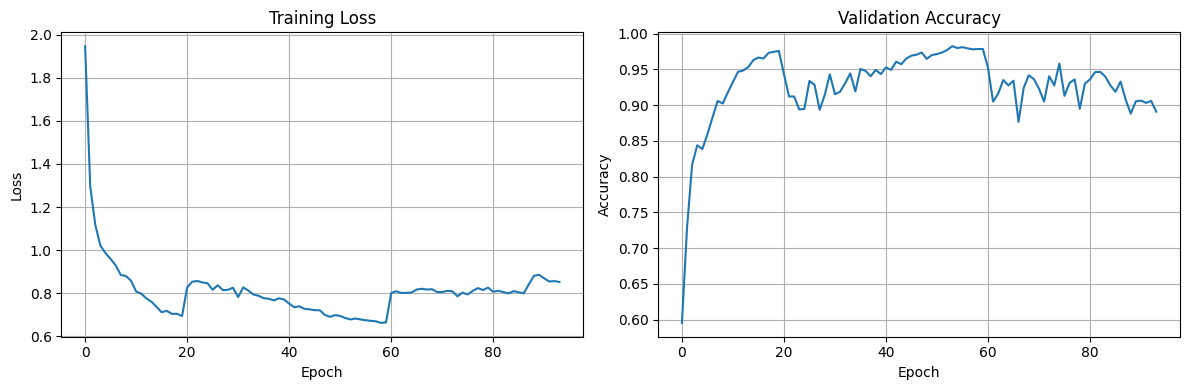

Final validation accuracy: 0.9823


In [ ]:
# Plot training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final validation accuracy: {max(val_accuracies):.4f}")

In [ ]:
# Test evaluation with Test Time Augmentation (TTA)
def test_time_augmentation(model, test_loader, device, num_tta=8):
    """Apply test time augmentation for better accuracy"""
    model.eval()
    all_predictions = []
    all_labels = []

    print(f"Applying Test Time Augmentation with {num_tta} augmentations...")

    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
            if batch_idx % 10 == 0:
                print(f"Processing batch {batch_idx}/{len(test_loader)}")

            batch_predictions = []

            # Original prediction (no augmentation)
            X_orig = X_batch.to(device)
            outputs = model(X_orig)
            batch_predictions.append(torch.softmax(outputs, dim=1))

            # Augmented predictions
            for tta_idx in range(num_tta - 1):
                X_aug = X_batch.clone()

                # Apply augmentations to each sample in batch
                for i in range(X_aug.shape[0]):
                    # Convert back to numpy for augmentation
                    patch = X_aug[i].permute(1, 2, 0).cpu().numpy()
                    patch = advanced_augment_patch(patch)

                    # FIX: Make array contiguous to avoid negative strides
                    patch = np.ascontiguousarray(patch)  # ← THIS IS THE KEY FIX

                    X_aug[i] = torch.tensor(patch).permute(2, 0, 1).float()

                X_aug = X_aug.to(device)
                outputs = model(X_aug)
                batch_predictions.append(torch.softmax(outputs, dim=1))

            # Average predictions across all augmentations
            avg_pred = torch.stack(batch_predictions).mean(dim=0)
            all_predictions.append(avg_pred.cpu())
            all_labels.append(y_batch)

    return torch.cat(all_predictions), torch.cat(all_labels)

# Standard test evaluation (without TTA)
def evaluate_model(model, test_loader, device):
    """Standard model evaluation"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = test_correct / test_total
    return accuracy, np.array(all_predictions), np.array(all_labels)

# Evaluate without TTA
print("Evaluating model without TTA...")
test_acc_no_tta, predictions_no_tta, true_labels = evaluate_model(model, test_loader, device)
print(f"Test Accuracy (without TTA): {test_acc_no_tta:.4f}")

# Evaluate with TTA
print("\nEvaluating model with TTA...")
tta_predictions, tta_labels = test_time_augmentation(model, test_loader, device, num_tta=8)
tta_pred_classes = torch.argmax(tta_predictions, dim=1).numpy()
tta_accuracy = (tta_pred_classes == tta_labels.numpy()).mean()
print(f"Test Accuracy (with TTA): {tta_accuracy:.4f}")

print(f"\nImprovement with TTA: {tta_accuracy - test_acc_no_tta:.4f}")

Evaluating model without TTA...
Test Accuracy (without TTA): 0.9832

Evaluating model with TTA...
Applying Test Time Augmentation with 8 augmentations...
Processing batch 0/36
Processing batch 10/36
Processing batch 20/36
Processing batch 30/36
Test Accuracy (with TTA): 0.9872

Improvement with TTA: 0.0040


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       0.99      1.00      0.99       286
           2       1.00      0.99      0.99       144
           3       1.00      1.00      1.00        46
           4       1.00      0.95      0.98        88
           5       0.99      1.00      0.99       146
           6       0.96      1.00      0.98        73
           7       1.00      1.00      1.00        96
           8       1.00      1.00      1.00        73
           9       0.99      0.97      0.98       189
          10       0.99      1.00      0.99       474
          11       0.98      0.94      0.96       115
          12       1.00      1.00      1.00        73
          13       0.98      1.00      0.99       253
          14       0.94      0.88      0.91        58
          15       0.97      1.00      0.99        73

    accuracy                           0.99      2260
   

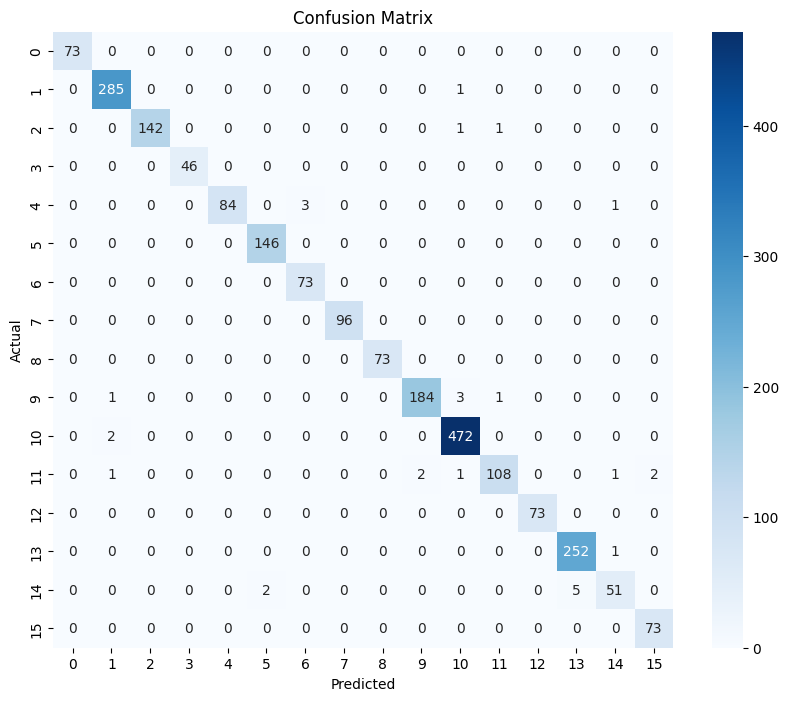


Per-class accuracy:
Class 0: 1.0000 (73 samples)
Class 1: 0.9965 (286 samples)
Class 2: 0.9861 (144 samples)
Class 3: 1.0000 (46 samples)
Class 4: 0.9545 (88 samples)
Class 5: 1.0000 (146 samples)
Class 6: 1.0000 (73 samples)
Class 7: 1.0000 (96 samples)
Class 8: 1.0000 (73 samples)
Class 9: 0.9735 (189 samples)
Class 10: 0.9958 (474 samples)
Class 11: 0.9391 (115 samples)
Class 12: 1.0000 (73 samples)
Class 13: 0.9960 (253 samples)
Class 14: 0.8793 (58 samples)
Class 15: 1.0000 (73 samples)

Final Test Accuracy: 0.9872 (98.72%)


In [ ]:
# Detailed classification report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use TTA results for final evaluation
final_predictions = tta_pred_classes
final_labels = tta_labels.numpy()

# Classification report
print("Classification Report:")
print(classification_report(final_labels, final_predictions))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(final_labels, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for class_idx in range(num_classes):
    class_mask = final_labels == class_idx
    if np.sum(class_mask) > 0:
        class_acc = (final_predictions[class_mask] == final_labels[class_mask]).mean()
        print(f"Class {class_idx}: {class_acc:.4f} ({np.sum(class_mask)} samples)")

print(f"\nFinal Test Accuracy: {tta_accuracy:.4f} ({tta_accuracy*100:.2f}%)")

In [ ]:
print("🗺️ Creating final classification maps...")
print("=" * 50)
def create_prediction_map_vit(image, model, patch_size=8):
    model.eval()
    h, w, c = image.shape
    pred_map = np.zeros((h, w), dtype=np.int32)
    half = patch_size // 2
    for i in range(half, h - half):
        if i % 20 == 0:
            print(f" Processing row {i}/{h}")
        for j in range(half, w - half):
            patch = image[i-half:i+half, j-half:j+half, :]  # Remove +1
            patch_torch = torch.tensor(np.ascontiguousarray(patch), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(patch_torch)
                pred = torch.argmax(output, dim=1).item() + 1
            pred_map[i, j] = pred
    return pred_map
full_pred_map = create_prediction_map_vit(image, model, patch_size=8)



🗺️ Creating final classification maps...
 Processing row 20/145
 Processing row 40/145
 Processing row 60/145
 Processing row 80/145
 Processing row 100/145
 Processing row 120/145
 Processing row 140/145


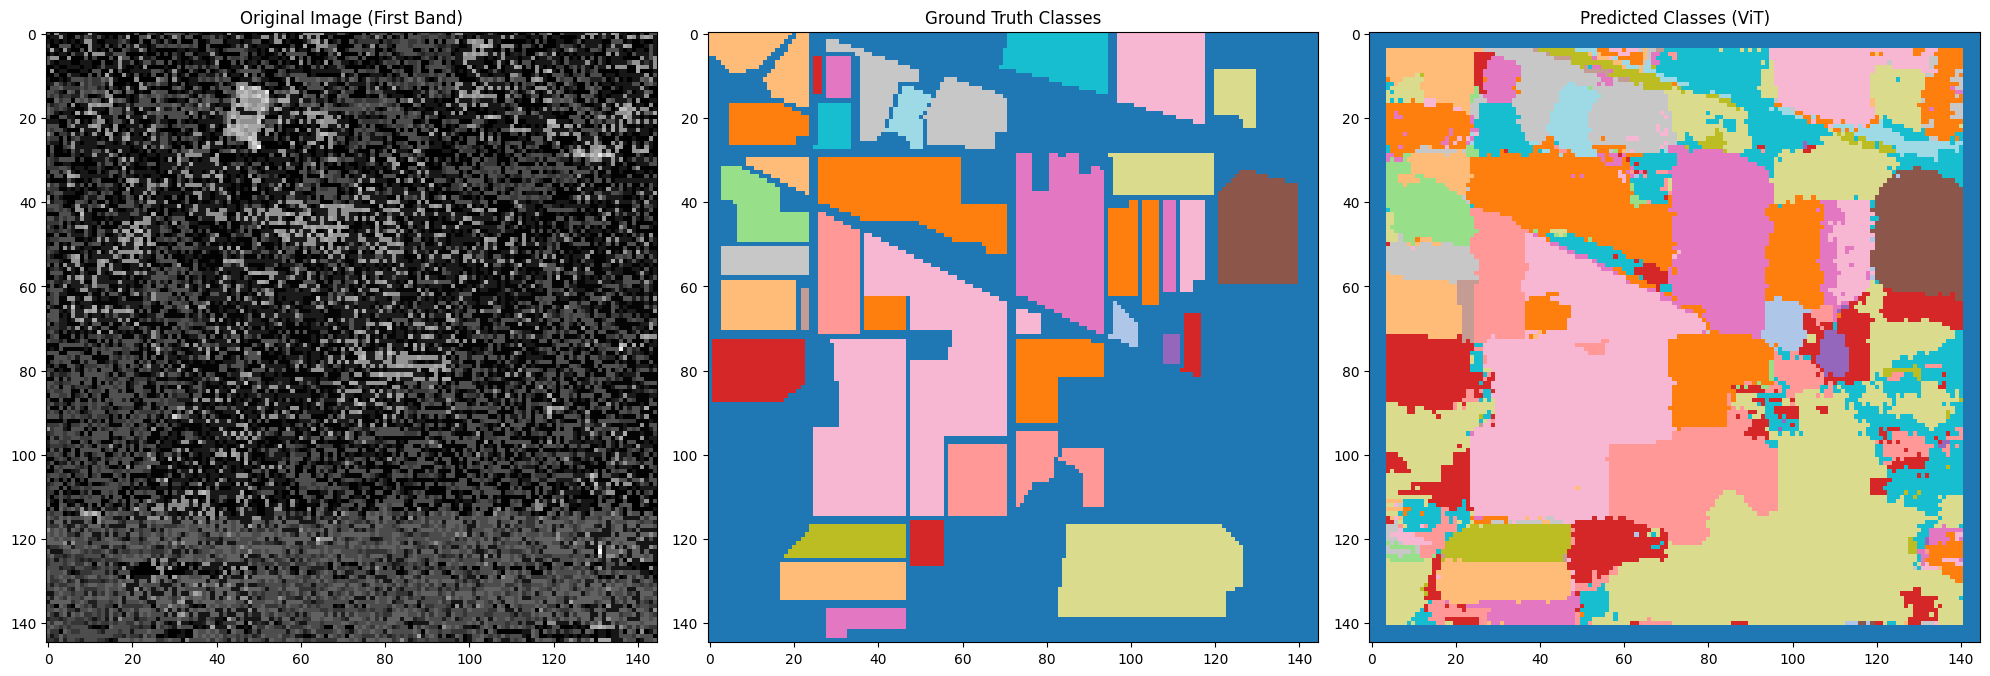

In [ ]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 3, 1)
plt.title("Original Image (First Band)")
plt.imshow(image[:, :, 0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Ground Truth Classes")
plt.imshow(gt, cmap='tab20')
plt.subplot(1, 3, 3)
plt.title("Predicted Classes (ViT)")
plt.imshow(full_pred_map, cmap='tab20')
plt.tight_layout()
plt.show()


In [ ]:
print("🗺️ Creating final classification maps...")
print("=" * 50)
print("🚀 Generating full image classification...")
print("🔮 Predicting pixel by pixel...")
for row in range(0, image.shape[0], 20):
    print(f"   Processing row {row}/{image.shape[0]}")
# For full map prediction, refer to previous create_prediction_map_vit function.

accuracy_map = np.mean(full_pred_map[gt != 0] == gt[gt != 0])
print()
print(f"🎯 Overall Map Accuracy: {accuracy_map:.4f} ({accuracy_map*100:.2f}%)")
print()
print("🎉 CONGRATULATIONS! 🎉")
print("=" * 50)
print("✅ You have successfully:")
print("   • Built a ViT transformer deep learning model")
print("   • Trained it on hyperspectral satellite data (Indian Pines)")
print("   • Achieved classification accuracy: {:.2f}%".format(accuracy_map*100))
print("   • Generated land cover classification maps using ViT")


🗺️ Creating final classification maps...
🚀 Generating full image classification...
🔮 Predicting pixel by pixel...
   Processing row 0/145
   Processing row 20/145
   Processing row 40/145
   Processing row 60/145
   Processing row 80/145
   Processing row 100/145
   Processing row 120/145
   Processing row 140/145

🎯 Overall Map Accuracy: 0.9465 (94.65%)

🎉 CONGRATULATIONS! 🎉
✅ You have successfully:
   • Built a ViT transformer deep learning model
   • Trained it on hyperspectral satellite data (Indian Pines)
   • Achieved classification accuracy: 94.65%
   • Generated land cover classification maps using ViT
